K-NN is nearest neighbour model (find k nearest datapoints and use to calculate estimate). works on a distance and decision metric which can be adapted to the problem. Limitations in high dimensions due to the curse of dimensionality. 


k in k-NN model similar to hyperparameter in regularization strength in ridge. Controls how "flexible" model is. Controls the over/under fit

In [2]:
import pandas as pd

data_df = pd.read_csv("c4_heart-numerical.csv")

data_df.head()

,age,trestbps,chol,thalach,oldpeak,ca,disease
0,63,145,233,150,2.3,0,absence
1,67,160,286,108,1.5,3,presence
2,67,120,229,129,2.6,2,presence
3,37,130,250,187,3.5,0,absence
4,41,130,204,172,1.4,0,absence


In [3]:
import numpy as np

# Create X/y arrays
X = data_df.drop("disease", axis=1).values
y = data_df.disease.values
print("X:", X.shape, X.dtype)
print("y:", y.shape, y.dtype)

X: (303, 6) float64
y: (303,) object


In [4]:
# Print labels
labels = np.unique(y)
print("Labels:", labels)

Labels: ['absence' 'presence']


In [5]:
from sklearn.model_selection import train_test_split

# Split data
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=0)

print("Train set:", X_tr.shape, y_tr.shape)
print("Test set:", X_te.shape, y_te.shape)

Train set: (212, 6) (212,)
Test set: (91, 6) (91,)


All the same as before however target variable is now categorical and has two possibilities

**Most Frequent Baseline**

In [6]:
# Count the number of entries labeled with 'absence'
n_absence = np.sum(y_tr == "absence")

print("Total absence:", n_absence)

Total absence: 117


In [9]:
# Probability of 'absence' in train set
p_absence = n_absence / len(y_tr)

print("Probability of absence: {:.2f}".format(p_absence))

# higher probability of absence

Probability of absence: 0.55


In [10]:
# On the test set
p_absence_te = np.sum(y_te == "absence") / len(y_te)

print("Probability of absence: {:.2f}".format(p_absence_te))

Probability of absence: 0.52


0.52 is the accuracy of the baseline model ie the error rate would be 0.48

*Multiple Classes*

In [11]:
# Compute distribution using Pandas
pd.Series(y_tr).value_counts() / len(y_tr)

absence     0.551887
presence    0.448113
dtype: float64

In [17]:
# Compute distribution using Pandas
pd.Series(y_tr).value_counts(normalize=True)

absence     0.551887
presence    0.448113
dtype: float64

*Scikit-learn Dummy Classifier*

In [18]:
# use to perform above

from sklearn.dummy import DummyClassifier

# Create the dummy classifier
dummy = DummyClassifier(strategy="most_frequent")

In [19]:
# Fit it
dummy.fit(None, y_tr)

# Compute test accuracy
accuracy = dummy.score(None, y_te)
print("Accuracy: {:.2f}".format(accuracy))

Accuracy: 0.52


**Confusion Matrix**

Accuracy score so far simply corresponds to amount of times predictions match true values. Tiem to look at where errors occur.

In [20]:
# "Most-frequent" predictions
y_pred_absence = dummy.predict(X_te)
print("Predicted:", y_pred_absence[:5], "..")
print("True labels:", y_te[:5], "..")

Predicted: ['absence' 'absence' 'absence' 'absence' 'absence'] ..
True labels: ['absence' 'absence' 'presence' 'absence' 'presence'] ..


In [21]:
from sklearn.metrics import confusion_matrix

# Confusion matrix
matrix = confusion_matrix(y_true=y_te, y_pred=y_pred_absence)
print(matrix)

[[47  0]
 [44  0]]


Easier to visualise this as a dataframe

In [22]:
# Confusion matrix as a DataFrame
matrix_df = pd.DataFrame(
    matrix,
    columns=["pred: absence", "pred: presence"],
    index=["true: absence", "true: presence"],
)

matrix_df

,pred: absence,pred: presence
true: absence,47,0
true: presence,44,0


Derive two important metrics from this RECALL & PRECISION 

**PRECISION**

=> how many times are we correct when predict positive?  precision = tp/(tp+fp)

In [24]:
from sklearn.metrics import precision_score

precision = precision_score(y_true=y_te, y_pred=y_pred_absence, pos_label="presence")

C:\Users\Rob\anaconda3\envs\adsml\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Error due to fact most frequent baseline never predicts presence

In [25]:
# Precision of the "always predicts presence" baseline
y_pred_presence = np.full_like(y_te, fill_value="presence")
precision_score(y_true=y_te, y_pred=y_pred_presence, pos_label="presence")  # ~ 0.48

0.4835164835164835

**RECALL**

recall measures “How many times do we predict positive when it is?”. recall = tp/(tp+fn)

In [27]:
from sklearn.metrics import recall_score

recall_score(y_true=y_te, y_pred=y_pred_absence, pos_label="presence")

0.0

In [28]:
# Recall of the "always predicts presence" baseline
recall_score(y_true=y_te, y_pred=y_pred_presence, pos_label="presence")  # 1.0

1.0

**F1 Score**

f1_score = 2 * (precision * recall) / (precision + recall)

In [30]:
from sklearn.metrics import f1_score

f1_score(y_true=y_te, y_pred=y_pred_presence, pos_label="presence")  # ~0.65

0.6518518518518518

**Classification Report**

In [31]:
from sklearn.metrics import classification_report

report = classification_report(y_true=y_te, y_pred=y_pred_presence, zero_division=0.0)
print(report)

              precision    recall  f1-score   support

     absence       0.00      0.00      0.00        47
    presence       0.48      1.00      0.65        44

    accuracy                           0.48        91
   macro avg       0.24      0.50      0.33        91
weighted avg       0.23      0.48      0.32        91



**Standardization**

Feature scale can impact k-NN model. A larger scale on one variable can cause model to favor it. Standardizing removes this as created an equal scale

*KNeighborsClassifier*

In [32]:
data_df.describe()

,age,trestbps,chol,thalach,oldpeak,ca
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.438944,131.689769,246.693069,149.607261,1.039604,0.663366
std,9.038662,17.599748,51.776918,22.875003,1.161075,0.934375
min,29.000000,94.000000,126.000000,71.000000,0.000000,0.000000
25%,48.000000,120.000000,211.000000,133.500000,0.000000,0.000000
50%,56.000000,130.000000,241.000000,153.000000,0.800000,0.000000
75%,61.000000,140.000000,275.000000,166.000000,1.600000,1.000000
max,77.000000,200.000000,564.000000,202.000000,6.200000,3.000000


In [34]:
from sklearn.model_selection import train_test_split

# assuming here that the data has already been split and this is the train set

# Create X/y arrays
X = data_df.drop("disease", axis=1).values
y = data_df.disease.values

# Split data
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.3, random_state=0)

In [35]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Create a k-NN pipeline
knn_pipe = Pipeline(
    [("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=5))]
)

# Fit estimator
knn_pipe.fit(X_tr, y_tr)

# Evaluate on validation set
accuracy = knn_pipe.score(X_val, y_val)
print("Accuracy: {:.3f}".format(accuracy))

Accuracy: 0.747


To experiment, view results without scaler

In [36]:
from sklearn.base import clone

knn_pipe2 = clone(knn_pipe)
knn_pipe2.set_params(scaler=None)
knn_pipe2.fit(X_tr, y_tr)
print("Accuracy: {:.3f}".format(knn_pipe2.score(X_val, y_val)))   #inferior result

Accuracy: 0.670


**Tuning k with Grid Search**

In [37]:
import numpy as np

# Generate a set of k values
k_values = np.r_[1, np.arange(5, 101, step=5)]
k_values

array([  1,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
        65,  70,  75,  80,  85,  90,  95, 100])

Run grid search with set_params and for loop

In [38]:
# [Code adapted from the previous course]
# Variable to store the results
gs_results = []

# Grid search
for k in k_values:
    # Fit k-NN model
    knn_pipe.set_params(knn__n_neighbors=k)
    knn_pipe.fit(X_tr, y_tr)

    # Save model and its performance on training/validation sets
    gs_results.append(
        {
            "k": k,
            "train_accuracy": knn_pipe.score(X_tr, y_tr),
            "valid_accuracy": knn_pipe.score(X_val, y_val),
        }
    )

# Convert results to DataFrame
gs_results = pd.DataFrame(gs_results)
gs_results.sort_values(by="valid_accuracy", ascending=False).head()

,k,train_accuracy,valid_accuracy
8,40,0.740566,0.780220
4,20,0.754717,0.780220
7,35,0.768868,0.780220
3,15,0.768868,0.769231
5,25,0.768868,0.769231


Optimal k value seems to be inbetween 20 & 40. plot for further clarity

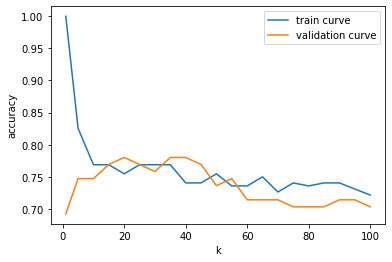

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot the validation curves
plt.plot(gs_results["k"], gs_results["train_accuracy"], label="train curve")
plt.plot(gs_results["k"], gs_results["valid_accuracy"], label="validation curve")
plt.ylabel("accuracy")
plt.xlabel("k")
plt.legend()
plt.show()

**Cross Validation: Averaging Several Runs**

In [40]:
# Run several times the evaluation
gs_results = []
for run_idx in range(30):
    # Split into training/validation sets
    X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.3, random_state=run_idx)

    # Grid search
    for k in k_values:
        # Fit k-NN model
        knn_pipe.set_params(knn__n_neighbors=k)
        knn_pipe.fit(X_tr, y_tr)

        # Save model and its performance on training/validation sets
        gs_results.append(
            {
                "k": k,
                "run_idx": run_idx,
                "train_accuracy": knn_pipe.score(X_tr, y_tr),
                "valid_accuracy": knn_pipe.score(X_val, y_val),
            }
        )

# Convert results to DataFrame
gs_results = pd.DataFrame(gs_results)

gs_results contains 30 scores for each k value.. group results and compute average scores

# Group results by alpha value
grouped = gs_results.groupby("k")

# Compute training/validation mean scores with std
mean_tr = grouped.train_accuracy.mean()
mean_te = grouped.valid_accuracy.mean()
std_tr = grouped.train_accuracy.std()
std_te = grouped.valid_accuracy.std()

Now plot average validation curves

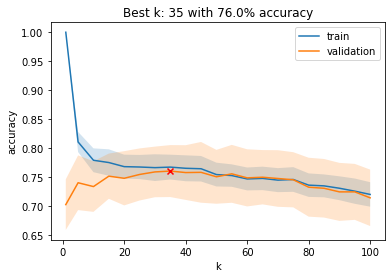

In [43]:
# Plot mean scores
plt.plot(k_values, mean_tr, label="train")
plt.plot(k_values, mean_te, label="validation")

# Add marker for best score
best_k = mean_te.idxmax()
plt.scatter(best_k, mean_te.max(), marker="x", c="red", zorder=10)

# Quantify variance with ±std curves
plt.fill_between(k_values, mean_tr - std_tr, mean_tr + std_tr, alpha=0.2)
plt.fill_between(k_values, mean_te - std_te, mean_te + std_te, alpha=0.2)
plt.title("Best k: {} with {:.1f}% accuracy".format(best_k, 100 * mean_te[best_k]))
plt.ylabel("accuracy")
plt.xlabel("k")
plt.legend()
plt.show()

"We can see that the scores on the training set vary less than the validation scores. But generally the size of variation of either set of scores is stable acoss different k values and the regions clearly overlap.

The best k value is around 35 with a mean accuracy of 76% and a standard deviation around 4%."

**Classification Report**

Previously based k-NN estimator on accuracy metric but others to consider

In [44]:
from sklearn.metrics import classification_report

# Tuned k-NN estimator
tuned_knn = Pipeline(
    [("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=best_k))]
)
tuned_knn.fit(X_tr, y_tr)

# Classification report
y_val_preds = tuned_knn.predict(X_val)
print(classification_report(y_true=y_val, y_pred=y_val_preds))

              precision    recall  f1-score   support

     absence       0.59      0.90      0.71        41
    presence       0.86      0.48      0.62        50

    accuracy                           0.67        91
   macro avg       0.72      0.69      0.66        91
weighted avg       0.74      0.67      0.66        91



Now we have best k value, possible to look into more. k-NN estimator retrieves k nearest patients within neighbourhood and predicts most frequent class. Can see proportions with predict_proba()

In [45]:
# Compute probabilities
y_val_probs = tuned_knn.predict_proba(X_val)
print("Predictions:", y_val_preds[:5])
print("Probs:")
print(y_val_probs[:5])

Predictions: ['absence' 'presence' 'presence' 'absence' 'presence']
Probs:
[[0.8        0.2       ]
 [0.14285714 0.85714286]
 [0.25714286 0.74285714]
 [0.74285714 0.25714286]
 [0.22857143 0.77142857]]


What this shows is that for the first prediction absence is returned as 80% of 35 nearest neighbours to the first patient in the valiation set are healthy and only 20% sick. Estimator labels patienst as sick when probability of scond column is more than 50%

**ROC Curve**

Possible to change value of this threshold. If we wanted to incraese number of times detected sick patient at cost of misclassifying healthy patients can review this by analyzing relationship on Receiver Operating Characteristic curve.

In [46]:
from sklearn.metrics import roc_curve

# ROC curve
fpr, tpr, thresholds = roc_curve(
    y_true=y_val, y_score=y_val_probs[:, 1], pos_label="presence"
)

The function returns three arrays

The False Positive Rate (FPR) - how many times we misclassify healthy patients.
The True Positive Rate (TPR) or Recall - how many times we correctly classify sick patients.
The associated threshold values

In [49]:
pd.DataFrame({"fpr": fpr, "tpr (recall)": tpr, "thresholds": thresholds})

,fpr,tpr (recall),thresholds
0,0.000000,0.00,1.942857
1,0.000000,0.02,0.942857
2,0.000000,0.06,0.885714
3,0.024390,0.12,0.857143
4,0.024390,0.18,0.828571
5,0.048780,0.20,0.771429
6,0.048780,0.26,0.742857
7,0.048780,0.28,0.685714
8,0.073171,0.32,0.657143
9,0.073171,0.36,0.571429


Each row tells us how small threshold should be to get at least associated recall value. For instance, with threshold smaller than 51.4% should get at least 48% recall. Default threshold of 50% get recall score 48%

Visualise this by plotting flase/true positive rates together

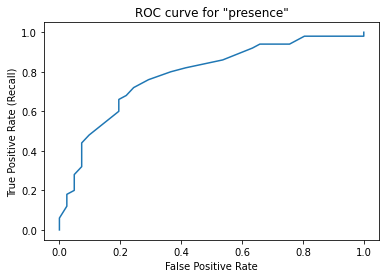

In [50]:
# Plot ROC curve
plt.plot(fpr, tpr, label="ROC curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title('ROC curve for "presence"')
plt.show()

Ideally curve would be as close to the upper left corner as possible (high recall and small false positive). Quantify this by computing "area" under this curve (AUC)

In [51]:
from sklearn.metrics import roc_auc_score

# Area under the curve (AUC)
roc_auc_score(y_true=y_val, y_score=y_val_probs[:, 1])

0.7858536585365854

Review the table of values it is possible to see row 21 is first threshold with recall score above 90% (92%)

In [52]:
# Adjust threshold
custom_preds = ["absence" if p else "presence" for p in (y_val_probs[:, 1] < 0.2)]

print(classification_report(y_true=y_val, y_pred=custom_preds))

              precision    recall  f1-score   support

     absence       0.79      0.37      0.50        41
    presence       0.64      0.92      0.75        50

    accuracy                           0.67        91
   macro avg       0.71      0.64      0.63        91
weighted avg       0.71      0.67      0.64        91

